In [1]:
from torch import nn
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.categorical import Categorical

In [2]:
import matplotlib.pyplot as plt

In [3]:
from Experiments.foong import Setup
device='cpu'
layerwidth=50
nblayers=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)
param_count=setup.param_count
logposterior=setup.logposterior

In [4]:
logtarget = logposterior

In [5]:
log_prob_func = logtarget

In [6]:
def leapfrog(params, momentum, log_prob_func, temperature, steps=10, step_size=0.1):
    def params_grad(p):
        p = p.detach().requires_grad_()
        global_log_prob = (log_prob_func(params)/temperature).sum()
        return torch.autograd.grad(global_log_prob, params)[0]

    momentum += 0.5 * step_size * params_grad(params)
    for n in range(steps):
        params = params + step_size * momentum
        p_grad = params_grad(params)
        momentum += step_size * p_grad
    momentum -= 0.5 * step_size * p_grad.clone()
    return params, momentum

In [8]:
def gibbs(params):
    dist = torch.distributions.Normal(torch.zeros_like(params), torch.ones_like(params))    
    return dist.sample()

In [9]:
def hamiltonian(params, momentum, log_prob_func, temperature):
    log_prob = log_prob_func(params)
    potential = -log_prob/temperature
    kinetic = 0.5 * (momentum**2).sum(dim=1)
    hamiltonian = potential + kinetic
    return hamiltonian

In [10]:
from tqdm.notebook import tqdm

In [11]:
nb_chain = 25
nb_iter = 2000
nb_inner = 5

nb_leapfrog = 25
step_size = .005

temperature = torch.linspace(torch.tensor(1.0).log(), torch.tensor(100000.0).log(), nb_chain).exp().to(device)

state = torch.rand((nb_chain, param_count), device=device)*0.00000001
acceptance = torch.zeros(nb_chain)
swapCount = torch.zeros((nb_chain,))
history = torch.zeros((nb_iter, nb_chain, param_count))
history[0] = state

In [12]:
#for t in range(1, nb_iter):
for t in tqdm(range(1, nb_iter)):
    state = state.detach().clone()
    params = state.detach().clone().requires_grad_()
    
    momentum = gibbs(params)
    ham = hamiltonian(params, momentum, log_prob_func, temperature)

    leapfrog_params, leapfrog_momenta = leapfrog(params, momentum, log_prob_func, temperature, steps=nb_leapfrog, step_size=step_size)

    params = leapfrog_params.detach().clone().requires_grad_()
    momentum = leapfrog_momenta
    new_ham = hamiltonian(params, momentum, log_prob_func, temperature)

    rho = -new_ham/temperature + ham/temperature
    accept = torch.rand(ham.shape, device=device).log() < rho
    
    state[accept,:] = params[accept,:]
    history[t] = state.detach().clone()
    
    acceptance += accept.cpu()*1.0
    
    # SWAP PHASE
    if t % nb_inner == 0:
        logProba = logtarget(state)
        for j in np.random.permutation(nb_chain-1):
            T_left = temperature[j]
            T_right = temperature[j+1]
            LP_left = logProba[j]
            LP_right = logProba[j+1]

            logA = LP_left/T_right + LP_right/T_left \
                 - LP_left/T_left - LP_right/T_right

            R = torch.exp(logA).cpu()

            if torch.rand(1)[0] < R:
                tmp = state[j,:].detach().clone() 
                state[j,:] = state[j+1,:].detach().clone() 
                state[j+1,:] = tmp

                tmp = logProba[j].detach().clone() 
                logProba[j] = logProba[j+1].detach().clone() 
                logProba[j+1] = tmp

                swapCount[j] += 1

In [13]:
acceptance/t

tensor([0.0030, 0.0110, 0.0180, 0.0590, 0.7474, 0.9330, 0.9785, 0.9960, 0.9985,
        0.9985, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [14]:
swapCount

tensor([ 73.,   7.,   8.,  13.,  30.,  81., 120., 116., 164., 192., 217., 244.,
        222., 226., 237., 262., 251., 265., 251., 275., 266., 264., 298., 296.,
          0.])

<IPython.core.display.Javascript object>


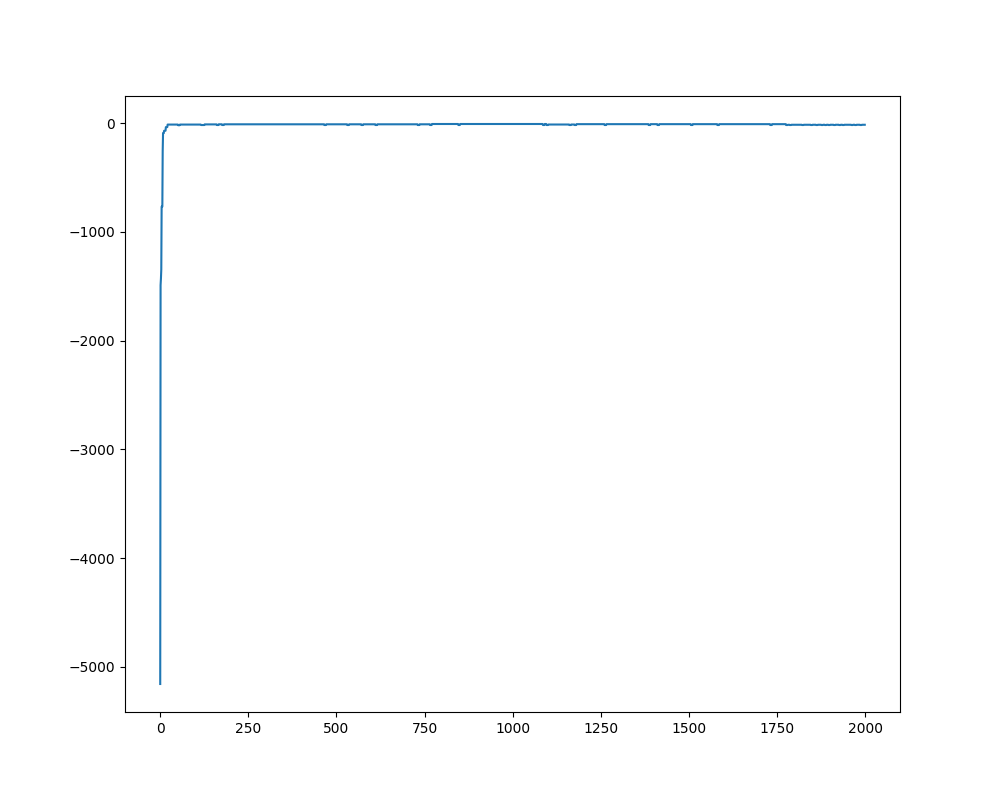

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
plt.plot(logtarget(history[:,0,:].to(device)).cpu().numpy())

In [16]:
x_lin = torch.linspace(-2.0, 2.0).unsqueeze(1)

In [20]:
y_ = setup._model(x_lin, history[0:,0,:]).detach().clone().cpu().numpy()

In [21]:
y_ = y_[:,:,0].transpose()

<IPython.core.display.Javascript object>


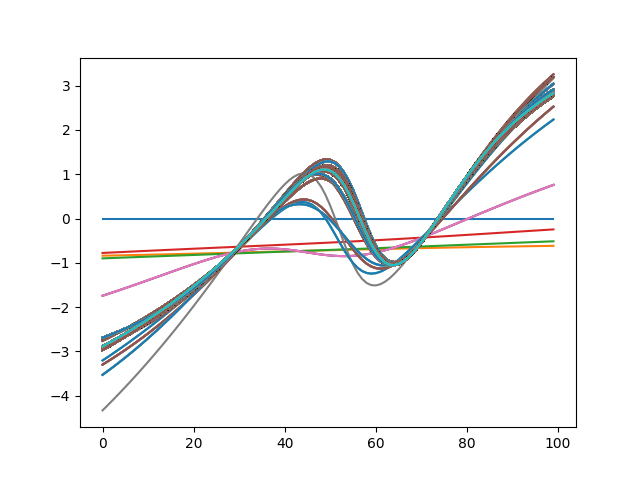

In [22]:
%matplotlib notebook
plt.plot(y_)
plt.show()